## Derivative Free Optimization: Genetic Algorithm
### Osvaldo Aldaz

Here, we will explore a path optimization example, trying to minimize the distance traveled between 2 nodes. Since the distances are discrete, trying to take a derivative and setting it to 0 isn't gonna work well here. So well explore the use of a derivative free optimize method known as a genetic algorithm structured similar to certain processes in nature.

Import Packages

In [239]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import imageio
import os
from IPython.display import Image, display

### Function to Generate Network:

In [240]:
def generate_random_road_network(num_nodes=50, connection_radius=0.2, seed=None,
                                  show_plot=True, show_dist=False, max_attempts=100,
                                  start_node=None, goal_node=None):
    """
    Generate a connected random geometric graph as a road network.

    Parameters:
    - num_nodes: number of intersections (nodes)
    - connection_radius: maximum distance to connect nodes
    - seed: random seed for reproducibility
    - show_plot: whether to show a plot of the network
    - max_attempts: max retries to generate a connected graph

    Returns:
    - G: a connected, weighted NetworkX graph with 'pos' attributes
    """
    if seed is not None:
        np.random.seed(seed)

    for attempt in range(max_attempts):
        # Generate random node positions in 2D
        pos = {i: np.random.rand(2) for i in range(num_nodes)}

        # Create graph
        G = nx.Graph()
        G.add_nodes_from(pos.keys())
        nx.set_node_attributes(G, pos, "pos")

        # Connect nodes within the radius
        for i in G.nodes:
            for j in G.nodes:
                if i < j:
                    dist = np.linalg.norm(pos[i] - pos[j])
                    if dist < connection_radius:
                        G.add_edge(i, j, weight=dist)

        # Check if graph is connected
        if nx.is_connected(G):

            if start_node is not None and goal_node is not None:
                start, goal = start_node, goal_node
                if start_node == goal_node or start_node >= num_nodes or goal_node >= num_nodes:
                    raise ValueError("Start and goal nodes must be different and within range.")
            else:
                start, goal = np.random.choice(num_nodes, 2, replace=False)



            if show_plot:
                plt.figure(figsize=(7, 6))
                nx.draw(G, pos, with_labels=True, node_size=300, node_color="limegreen")
                nx.draw_networkx_nodes(G, pos, nodelist=[start], node_color="skyblue", label="Start (A)")
                nx.draw_networkx_nodes(G, pos, nodelist=[goal], node_color="red", label="Goal (B)")

                label_offset = 0.05  # tweak this to move label further away if needed
                pos_labels = {
                    start: (pos[start][0] + label_offset, pos[start][1] - 1.5*label_offset),
                    goal: (pos[goal][0] - label_offset, pos[goal][1] + 1.5*label_offset)
                }  
            
                nx.draw_networkx_labels(G, pos_labels, labels={start:"Start", goal:"Goal"},
                                         font_size= 28, font_color="black")

                if show_dist:
                    labels = nx.get_edge_attributes(G, 'weight')
                    nx.draw_networkx_edge_labels(G, pos, edge_labels={e: f"{w:.2f}" for e, w in labels.items()})
                
                plt.title("Random Road Network")
                plt.axis("equal")
                plt.grid(True, alpha=0.3)
                plt.show()
            return G, start, goal, pos

    raise ValueError(f"Failed to generate a connected graph after {max_attempts} attempts.")


#### Generate Roads
Use a seed to set a random network, leave it undefined to randomly generate upon each run. Start node is red, goal node to reach is Blue. The network generated here will be used for the rest of the run

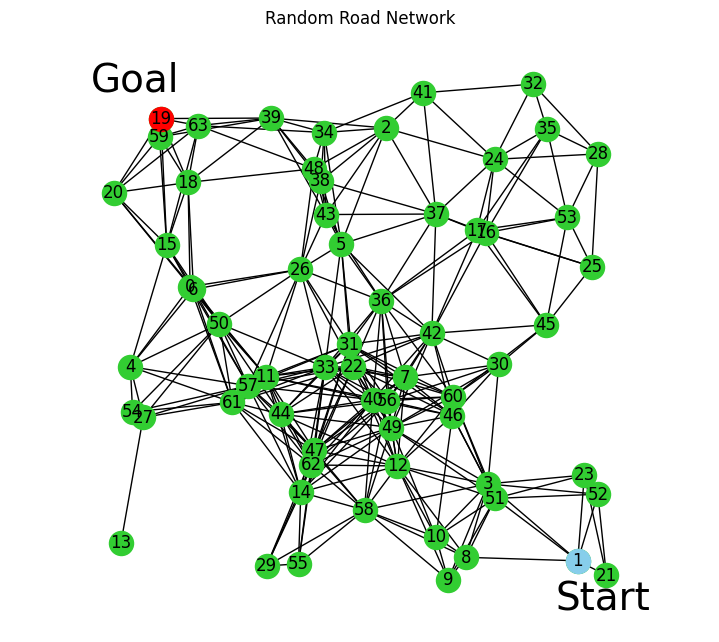

In [241]:
G, A, B, pos = generate_random_road_network(num_nodes=64, connection_radius=0.25, seed=3438, start_node=1, goal_node=19)

#G, A, B = generate_random_road_network(num_nodes=16, connection_radius=0.25, show_plot=True)

#### Helper functions to generate and validate paths

In [242]:

def random_valid_path(G, start, goal, max_steps=100):
    """
    Random walk from start to goal to generate an initial genome (path).
    May return invalid path if goal isn't reachable within max_steps.
    """
    path = [start]
    current = start
    for _ in range(max_steps):
        neighbors = list(G.neighbors(current))
        if not neighbors:
            break  # dead end
        next_node = random.choice(neighbors)
        path.append(next_node)
        current = next_node
        if current == goal:
            return path
    return path  # may not reach goal

def is_valid_path(path, G):
    return all(G.has_edge(path[i], path[i+1]) for i in range(len(path)-1))

def path_length(path, G):
    return sum(G[path[i]][path[i+1]]['weight'] for i in range(len(path)-1))

def evaluate_fitness(path, G, goal):
    if not is_valid_path(path, G):
        return float('inf')  # invalid path
    if path[-1] != goal:
        return float('inf')  # didn't reach goal
    return path_length(path, G)



### Path genetics
The crossover function creates a new path by combining 2 valid paths, while the mutate function randomly changes a part of the path. Togther, they spiritaully combine to reflect nature, with 2 parent coming togther to produce a child that is very similar to both parents, with slight differences.

In [243]:
def crossover(parent1, parent2, start, goal):
    common_nodes = set(parent1[1:-1]) & set(parent2[1:-1])
    if not common_nodes:
        return parent1  # fallback if no common node
    crossover_node = random.choice(list(common_nodes))
    i = parent1.index(crossover_node)
    j = parent2.index(crossover_node)
    child = parent1[:i] + parent2[j:]
    return child


def mutate(path, G, mutation_rate=0.2):
    if len(path) <= 2:
        return path  # nothing to mutate

    if random.random() < mutation_rate:
        # Randomly choose a node to mutate (not start/goal)
        idx = random.randint(1, len(path)-2)
        current = path[idx - 1]
        # Replace the rest of the path with a new random walk
        try:
            new_path = random_valid_path(G, current, path[-1])
            return path[:idx] + new_path[1:]
        except:
            return path  # fallback
    return path


### Plotting Function
Plots road network with paths highlighted

In [244]:
def plot_path(G, pos, path, start, goal, generation=None, save_path=None):
    plt.figure(figsize=(7, 6))
    nx.draw(G, pos, with_labels=True, node_size=300, node_color="lightgray")
    nx.draw_networkx_nodes(G, pos, nodelist=[start], node_color="skyblue", label="Start (A)")
    nx.draw_networkx_nodes(G, pos, nodelist=[goal], node_color="red", label="Goal (B)")
    nx.draw_networkx_edges(G, pos)

    # Highlight path
    edge_list = [(path[i], path[i+1]) for i in range(len(path)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=edge_list, edge_color="blue", width=3)

    # Dynamic title
    if generation is not None:
        plt.title(f"Generation {generation} - Best Path")
        plt.text(0.01, 0.99, f"Gen {generation}", transform=plt.gca().transAxes,
                 fontsize=12, color='black', verticalalignment='top',
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    else:
        plt.title("Best Path Found")

    plt.axis("equal")
    plt.grid(True, alpha=0.3)

    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()


# Genetic Algorithm
This is the bulk of the optimization, where the process seeks to improve over generations without the need of derivatives. 

It starts by generating a batch of paths, known as a 'population'. Then each path is scored, in this case the shortest the total distance of the path the better. Then the best performing paths are used to make "offspring", in which the parent paths are spliced together with some mutations to produce a 'child' path. These children then make up the next generation, and the cycle restarts from path evaluation.

The algorithm stops after reaching a desired efficacy or after a set number of generations, with the optimal solution being approached over generations.

In [ ]:
def genetic_algorithm(G, start, goal, pop_size=100, generations=100, mutation_rate=0.2,
                      save_frames=False, output_dir="frames", pos=None, Logs=False):
    if pos is None:
        pos = nx.spring_layout(G, seed=3430)


    if save_frames:
        output_dir = "frames"
        os.makedirs(output_dir, exist_ok=True)
    
    # Generate initial batch of paths
    population = [random_valid_path(G, start, goal) for _ in range(pop_size)]
    best_paths = []

    for gen in range(generations):
        # Evaluate paths
        fitness_scores = [evaluate_fitness(p, G, goal) for p in population]

        # Select the best individuals
        sorted_pop = [p for _, p in sorted(zip(fitness_scores, population), key=lambda x: x[0])]
        population = sorted_pop[:pop_size // 2]  # keep top 50%

        # Generate new individuals through crossover and mutation
        new_population = population.copy()
        while len(new_population) < pop_size:
            parents = random.sample(population, 2)
            child = crossover(parents[0], parents[1], start, goal)
            child = mutate(child, G, mutation_rate)
            new_population.append(child)

        population = new_population

        # Track and log the best individual of this generation
        best_individual = min(population, key=lambda p: evaluate_fitness(p, G, goal))
        best_paths.append(best_individual)

        best_score = evaluate_fitness(best_individual, G, goal)
        if Logs:
            print(f"Generation {gen+1}, Best path length: {best_score:.2f}")

        # Save a frame for GIF creation
        if save_frames and pos is not None:
            frame_path = os.path.join(output_dir, f"gen_{gen:03d}.png")
            plot_path(G, pos, best_individual, start, goal, generation=gen, save_path=frame_path)

    # Final best path
    final_scores = [evaluate_fitness(p, G, goal) for p in population]
    best_idx = min(range(len(final_scores)), key=lambda i: final_scores[i])

    return population[best_idx], final_scores[best_idx], pos


Function to generate GIF for visualization

In [246]:

def create_gif_from_frames(frame_dir, output_gif, fps=5):
    frames = sorted(
        [os.path.join(frame_dir, f) for f in os.listdir(frame_dir) if f.endswith('.png')]
    )

    images = [imageio.imread(frame) for frame in frames]
    imageio.mimsave(output_gif, images, fps=fps)
    print(f"GIF saved to {output_gif}")

# Run Simulation
Play around with different paramters, such as # of generation, mutation rate, and even go back up to use a different road network. You'll notice that increasing generations leads to better paths, but at the cost of increased computational cost. This is more noticable with larger networks. 

In [250]:
best_path, best_length, pos = genetic_algorithm(G, A, B, generations=30, save_frames=True,
                                                 pos=pos, mutation_rate=0.3)
print(f"Best path: {best_path} with distance {best_length:.2f}")

create_gif_from_frames("frames", "evolution.gif", fps=3)

Best path: [1, 3, 60, 42, 5, 48, 39, 19] with distance 1.29


C:\Users\Osvaldo A\AppData\Local\Temp\ipykernel_124\3377199376.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(frame) for frame in frames]


GIF saved to evolution.gif


## Animate Results

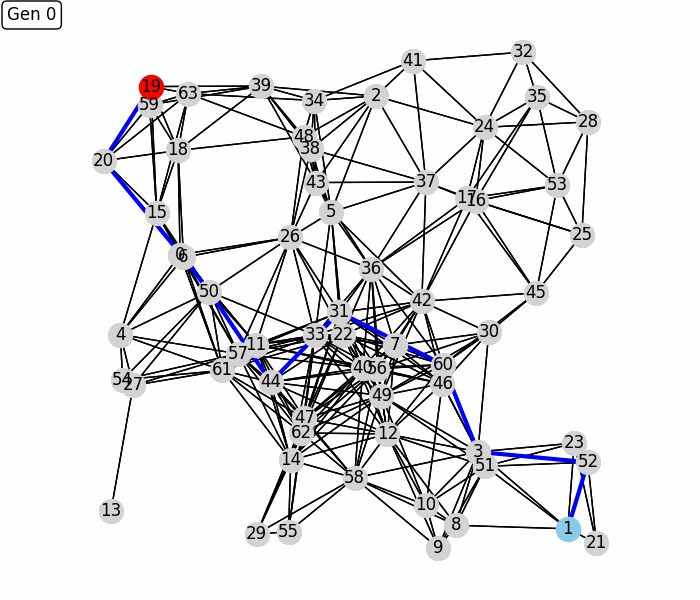

In [251]:
display(Image(filename="evolution.gif"))